In [24]:
FROM_DATASET = False
N_SAMPLES = 5000
PARTITION = int(N_SAMPLES*0.1)
ITERS = 30
EPSILON = 1e-5

In [25]:
from sklearn.datasets import make_blobs, make_moons
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import collections
import scipy
import time
import math

In [26]:
#diabetes, Surgical-deepnet
DATABASE = 'Surgical-deepnet' 

Shape of X: (5000, 2)
Shape of y: (5000,)


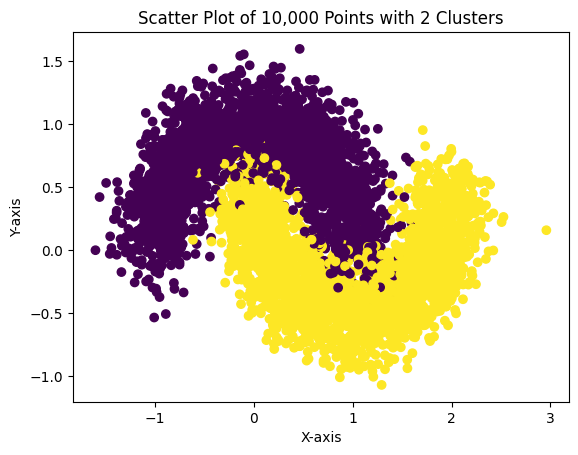

In [27]:

if not FROM_DATASET:
    # Set random seed for reproducibility
    np.random.seed(420)

    # Create dataset with 10,000 points and 2 clusters
    #X, y = make_blobs(n_samples=N_SAMPLES, centers=2, cluster_std=1.5)
    X, y = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state=420)
    y = np.where(y == 0, -1, y)

    # Print the shapes of X and y
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)

    # Create scatter plot
    plt.scatter(X[:, 0], X[:, 1], c=y)

    # Add axis labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Scatter Plot of 10,000 Points with 2 Clusters')

    # Show the plot
    plt.show()

else:

    if DATABASE == "diabetes":
        data = np.genfromtxt('diabetes.csv', delimiter=',', skip_header=1)
        X = data[:, :-1]
        y = data[:, -1]
        y = np.where(y == 0, -1, y)

        print("Shape 1: " +  str(X.shape))
        X = PCA(n_components=2).fit_transform(X)
        print("Shape 2: " +  str(X.shape))

    elif DATABASE == "Surgical-deepnet":
        data = np.genfromtxt('Surgical-deepnet.csv', delimiter=',', skip_header=1)
        X = data[:, : -1]
        y = data[:, -1]
        y = np.where(y == 0, -1, y)

        print("Shape 1: " +  str(X.shape))
        X = PCA(n_components=5).fit_transform(X)
        print("Shape 2: " +  str(X.shape))


In [28]:
print("Dataset Lenght")
print("Tot: " + str(len(X)) + ", lab: " + str(PARTITION) + ", unlab: " + str(len(X)-PARTITION))

X.shape

Dataset Lenght
Tot: 5000, lab: 500, unlab: 4500


(5000, 2)

In [29]:
# Points initialization
labeled_X = np.array(X[:PARTITION])
unlabeled_X = np.array(X[PARTITION:])

# Label initialization
labeled_y = np.array(y[:PARTITION])
target_y = np.array(y[PARTITION:])
initial_y = np.random.choice([-1,1], size = (len(unlabeled_X,)))

### Labeled-Unlabeled distances

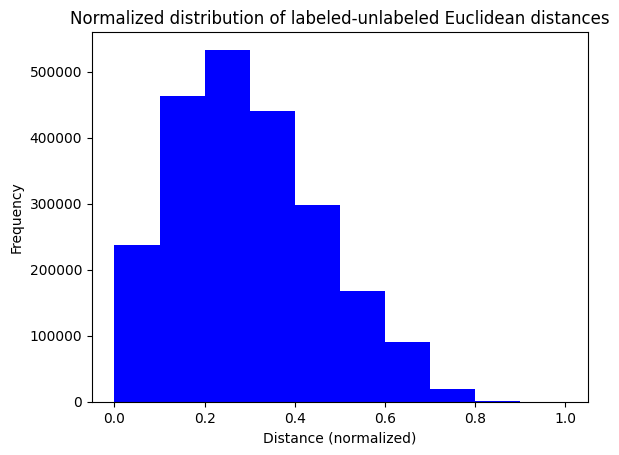

In [30]:

# Calculate distances
labeled_distances = cdist(labeled_X, unlabeled_X)

# Normalize the distances
max_distance = np.max(labeled_distances)
labeled_normalized_distances = labeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(labeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of labeled-unlabeled Euclidean distances')

# Show the plot
plt.show()

### Unlabeled-Unlabeled distances

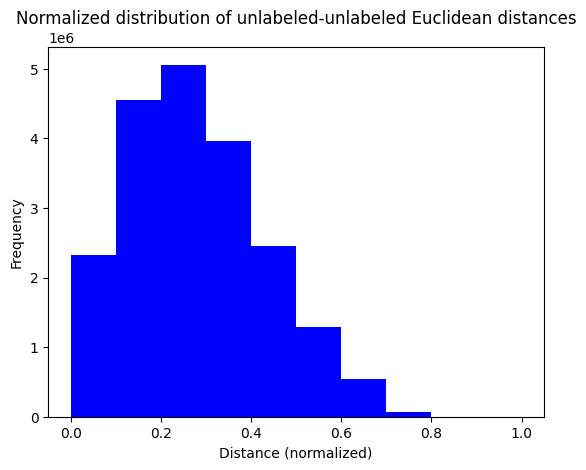

In [31]:
unlabeled_distances = cdist(unlabeled_X, unlabeled_X)

# Normalize the distances
max_distance = np.max(unlabeled_distances)
unlabeled_normalized_distances = unlabeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(unlabeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of unlabeled-unlabeled Euclidean distances')

# Show the plot
plt.show()


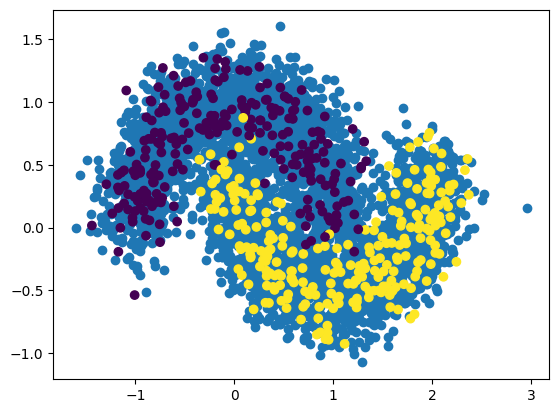

In [32]:
if not FROM_DATASET:
    plt.scatter(unlabeled_X[:, 0], unlabeled_X[:, 1])
    plt.scatter(labeled_X[:, 0], labeled_X[:, 1], c=labeled_y)
    plt.show()

## Calculating Weights

For the weights, the following is the function that has been choosen:

$$
dist(a,b) = e^{-100 ||a-b||^2_2}
$$

In [33]:
def weight(dist): 
    return math.e**(-100*dist**2)

In [34]:
%%time
print("Computing weights")
labeled_unlabeled_weights = np.vectorize(weight)(labeled_normalized_distances)
unlabeled_unlabeled_weights = np.vectorize(weight)(unlabeled_normalized_distances)
print('Done')

Computing weights
Done
CPU times: user 10.3 s, sys: 1.64 s, total: 11.9 s
Wall time: 12.6 s


The following is the implementations of the loss function:
$$
f(y) = \sum_{i=0}^l\sum_{j=0}^u w_{ij}(y^j -\bar{y}^i)^2 + \frac{1}{2} \sum_{i=0}^u\sum_{j=0}^u \bar{w}_{ij}(y^j -y^i)^2
$$
the following function is using linear algebra and Numpy to calcolate it, in order to have decent performance

In [42]:
def loss(labeled, unlabeled):
    Y = np.copy(unlabeled).astype("float64").reshape((-1,1))
    Y_bar = np.copy(labeled).astype("float64").reshape((-1,1))

    labeled_unlabeled_loss = np.sum(
        np.power(Y - Y_bar.T, 2) * labeled_unlabeled_weights.T
        )

    unlabeled_unlabeled_loss = np.sum(
        np.power(Y - Y.T, 2) * unlabeled_unlabeled_weights.T
        )

    return labeled_unlabeled_loss + unlabeled_unlabeled_loss/2

The following is a function used to calcolate the accuracy, comparing the targets and the current estimation (it's necessary in order to take care of the fact that the current is composed by number in $R \in\ [-1, 1]$ where the target is in $\{-1, 1\}$)

In [36]:
def accuracy(current):
    return np.sum(np.equal((current/2 + .5).round() * 2 - 1, target_y)) / len(target_y)

### Hessian and Lipschitz constant

Those functions are used to calculate the Hessian matrix and the Lipschitz constat for the whole problem, and for the single variable.
The Hessian is calculated as follows:


In [55]:
def hessian_matrix(unlabeled_unlabeled_w, labeled_unlabeled_w):
    matrix = np.copy(-unlabeled_unlabeled_w)
    
    for i in range(len(target_y)):
        matrix[i][i] = 2 * np.sum(labeled_unlabeled_w[:,i]) + np.sum(unlabeled_unlabeled_w[:,i]) - unlabeled_unlabeled_w[i][i]
    return matrix

def lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]
    
def is_strongly_convex(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]


In [56]:
%%time
print("Hessian matrix")
hessian = hessian_matrix(unlabeled_unlabeled_weights, labeled_unlabeled_weights)

print("Calculating sigma (strongly convex)")
sigma = is_strongly_convex(hessian)
is_sc = sigma > 0

if is_sc: print(f"Sigma: {sigma}, strongly convex")
else: print(f"Sigma: {sigma}, not strongly convex")

L = lipschitz_constant(hessian)
print(f"Lipschitz constant: {L}")

print("Lipschitz constant for single variable")
Li = np.repeat(L, len(hessian))

Hessian matrix
Calculating sigma (strongly convex)
Sigma: 9.647334167819288, strongly convex
Lipschitz constant: 733.5584834734199
Lipschitz constant for single variable
CPU times: user 1min 12s, sys: 44 s, total: 1min 56s
Wall time: 22.6 s


## Gradient Descent Methods

Following is the function used to calculate the gradient, which for a single variable is:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})y^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

Following are some constant that are going to be used in the gradient, since it can rewritten in a format which allows to avoid having to redo those calculation each time

In [64]:
print("Calculating coefficients of the gradient")

label_unlabel_tot = np.sum(labeled_unlabeled_weights, axis=0).reshape((-1,1))
unlabel_unlabel_tot = np.sum(unlabeled_unlabeled_weights, axis=0).reshape((-1,1))

grad_first_coeff_vec = (2 * label_unlabel_tot) + unlabel_unlabel_tot
grad_second_coeff_vec = 2 * np.multiply(
    labeled_y.reshape((-1,1)),
    labeled_unlabeled_weights
).sum(0).reshape((-1,1))

print("Done")

Calculating coefficients of the gradient
Done


In [39]:
def gradient(unlabeled):
    unlabeled = unlabeled.reshape((-1,1))
    third_coeff = np.multiply(
        unlabeled,
        unlabeled_unlabeled_weights
    ).sum(0).reshape((-1,1))
    return (grad_first_coeff_vec * unlabeled - grad_second_coeff_vec - third_coeff).reshape((-1,))

### Gradient Descent

Creating a copy of the defined initialization, in order to have the same also in the following algorithms

In [40]:
y_unlabeled_gd = np.copy(initial_y)

In [41]:
%%time
ticks_gd = [0]
accuracies_gd = [accuracy(y_unlabeled_gd)]
losses_gd = [loss(labeled_y, y_unlabeled_gd)]
init_time = time.time() * 1000

for i in range(ITERS):
    if i % (ITERS * 0.1) == 0 :
        print(f"{int(i/ITERS*100):02}% - iter {i} / {ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd = y_unlabeled_gd - 1/L * grad
    accuracies_gd.append(accuracy(y_unlabeled_gd))
    losses_gd.append(loss(labeled_y, y_unlabeled_gd))
    ticks_gd.append(time.time() * 1000 - init_time)

    if i % (ITERS * 0.1) == 0 :
        print(f" - final accuracy {(accuracies_gd[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_gd):05.2f}")
        
print(f"""
Final accuracy: {round(accuracies_gd[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd))}
Loss: {loss(labeled_y, y_unlabeled_gd)}
""")

00% - iter 0 / 30 - final accuracy 62.96% - loss 320415.09
10% - iter 3 / 30 - final accuracy 92.51% - loss 154784.27
20% - iter 6 / 30 - final accuracy 92.44% - loss 143679.86
30% - iter 9 / 30 - final accuracy 92.02% - loss 141997.25
40% - iter 12 / 30 - final accuracy 91.82% - loss 142278.72
50% - iter 15 / 30 - final accuracy 91.71% - loss 142877.60
60% - iter 18 / 30 - final accuracy 91.64% - loss 143394.36


KeyboardInterrupt: 

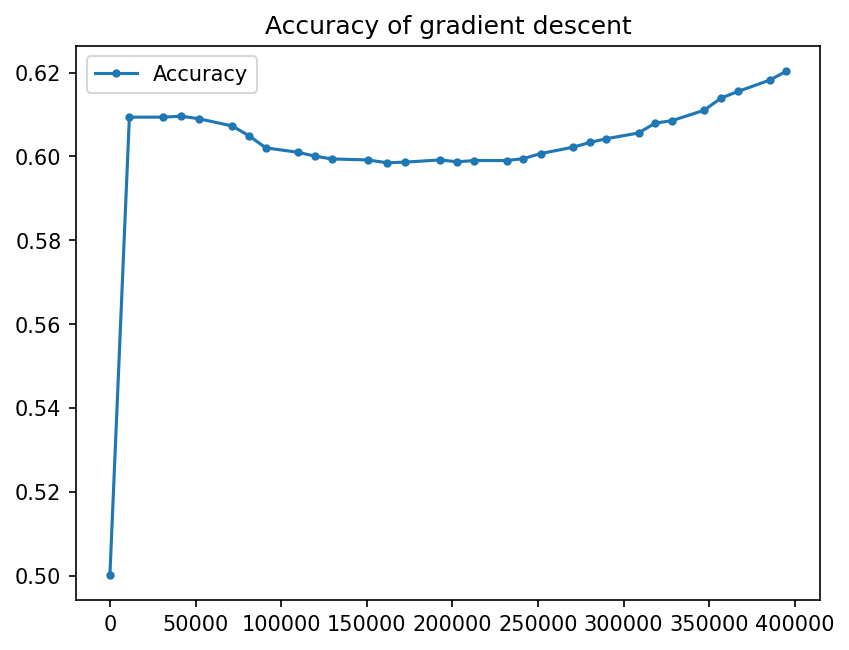

In [39]:
plt.figure(dpi=150)
plt.title("Accuracy of gradient descent")
plt.plot(ticks_gd, accuracies_gd, marker='.')
plt.legend(["Accuracy"])

### Gradient Descent with improved rate

This implementation of the GD algorithm with use:
$$
\alpha_k = $\frac{2}{L+sigma}$
$$
in case the problem is strongly convex

In [40]:
y_unlabeled_gd_improved = np.copy(initial_y)

In [41]:
%%time
ticks_gd_improved = [0]
accuracies_gd_improved = [accuracy(y_unlabeled_gd_improved)]
losses_gd_improved = [loss(labeled_y, y_unlabeled_gd_improved)]
init_time = time.time() * 1000

for i in range(ITERS):
    if i % (ITERS * 0.1) == 0 :
        print(f"{int(i/ITERS*100):02}% - iter {i} / {ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd_improved)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd_improved = y_unlabeled_gd_improved - (2 if is_sc else 1)/(L + (sigma if is_sc else 0)) * grad
    accuracies_gd_improved.append(accuracy(y_unlabeled_gd_improved))
    losses_gd_improved.append(loss(labeled_y, y_unlabeled_gd_improved))
    ticks_gd_improved.append(time.time() * 1000 - init_time)

    if i % (ITERS * 0.1) == 0 :
        print(f" - final accuracy {(accuracies_gd_improved[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_gd_improved):05.2f}")
print(f"""
Final accuracy: {round(accuracies_gd_improved[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_improved))}
Loss: {loss(labeled_y, y_unlabeled_gd_improved)}
""")

00% - iter 0 / 30 - final accuracy 49.94% - loss 9898492.41
10% - iter 3 / 30

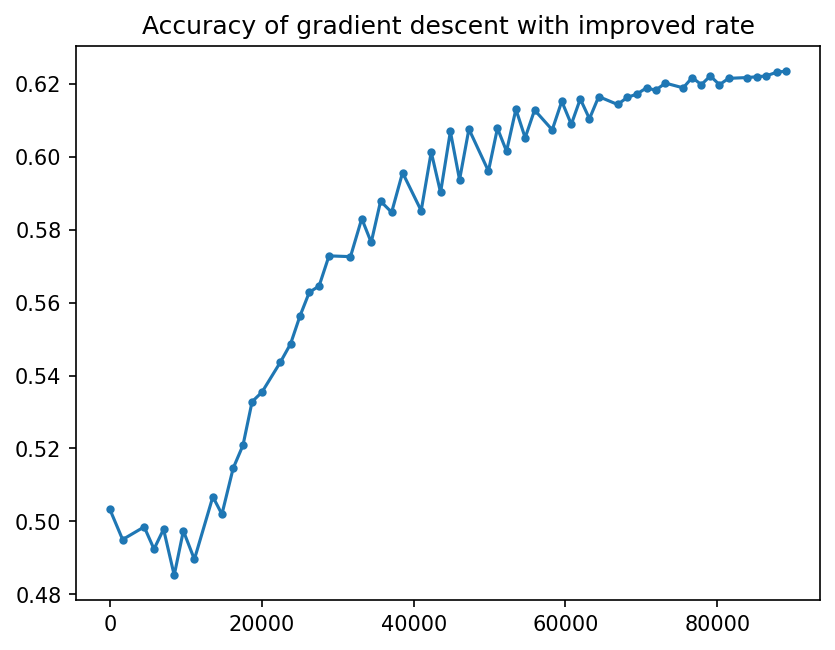

In [ ]:
plt.figure(dpi=150)
plt.title("Accuracy of gradient descent with improved rate")
plt.plot(ticks_gd_improved, accuracies_gd_improved, marker='.')

## Block Coordinate Gradient Method

Following is the function used to find the derivative in respect to a single variable:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})\bar{y}^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [ ]:
def update_gradient(previous_grad, Li, index):
    global unlabeled_unlabeled_weights, grad_first_coeff_vec
    step = 1/Li[index] * previous_grad[index]
    new_grad = np.copy(previous_grad)
    new_grad += unlabeled_unlabeled_weights[index] * step
    new_grad[index] -= grad_first_coeff_vec[index] * step
    return step, new_grad

### Randomized

In [ ]:
y_unlabeled_bcgd_random = np.copy(initial_y).astype("float64")

In [ ]:
%%time
ticks_bcgd_random= [0]
accuracies_bcgd_random= [accuracy(y_unlabeled_bcgd_random)]
losses_bcgm_random = [loss(labeled_y, y_unlabeled_bcgd_random)]

optimized_sampling_probabilities = np.copy(Li) / np.sum(Li)
previous_grad_random = gradient(y_unlabeled_bcgd_random)
max_iterations = ITERS*len(y_unlabeled_bcgd_random)
indexes = np.random.randint(0, len(y_unlabeled_bcgd_random), max_iterations)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * 0.1) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = indexes[i]

    step, new_grad = update_gradient(previous_grad_random, Li, index)
    y_unlabeled_bcgd_random[index] = y_unlabeled_bcgd_random[index] - step
    previous_grad_random = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_random):
        break

    if (i+1) % len(target_y) == 0:

        accuracies_bcgd_random.append(accuracy(y_unlabeled_bcgd_random))
        losses_bcgm_random.append(loss(labeled_y, y_unlabeled_bcgd_random))
        ticks_bcgd_random.append(time.time() * 1000 - init_time)

    if i % (max_iterations * 0.1) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_random[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_bcgd_random):05.2f}")

print(f"""
Final accuracy: {round(accuracies_bcgd_random[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_random))}
Loss: {loss(labeled_y, y_unlabeled_bcgd_random)}
""")

00% - iter 0 / 276000 - final accuracy 50.33% - loss 20706455.27
10% - iter 27600 / 276000 - final accuracy 63.70% - loss 1531522.52
20% - iter 55200 / 276000 - final accuracy 63.59% - loss 1476954.12
30% - iter 82800 / 276000 - final accuracy 63.59% - loss 1474973.73
40% - iter 110400 / 276000 - final accuracy 63.59% - loss 1474514.29
50% - iter 138000 / 276000 - final accuracy 63.59% - loss 1474399.83
60% - iter 165600 / 276000 - final accuracy 63.59% - loss 1474366.63
70% - iter 193200 / 276000 - final accuracy 63.59% - loss 1474351.90
80% - iter 220800 / 276000 - final accuracy 63.59% - loss 1474342.52
90% - iter 248400 / 276000 - final accuracy 63.57% - loss 1474337.71

Final accuracy: 63.57%
Norm gradient: 38.435436161534994
Loss: 1474334.7402749478

CPU times: user 1min 17s, sys: 12.8 s, total: 1min 30s
Wall time: 1min 32s


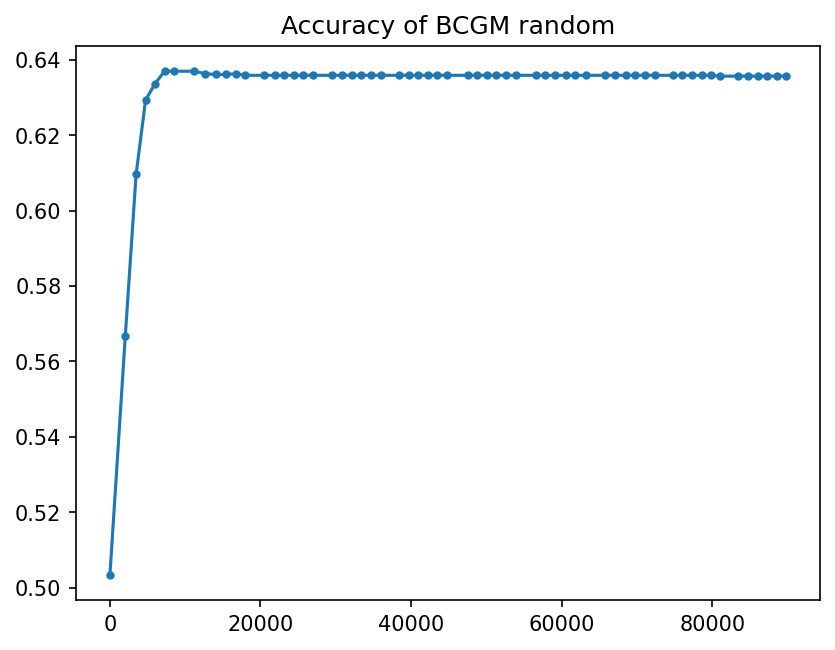

In [ ]:
plt.figure(dpi=150)
plt.title("Accuracy of BCGM random")
plt.plot(ticks_bcgd_random, accuracies_bcgd_random, marker='.')

### Gauss-Southwell

In [ ]:
y_unlabeled_bcgd_gs = np.copy(initial_y).astype("float64")

In [ ]:
%%time
ticks_bcgd_gs = [0]
accuracies_bcgd_gs = [accuracy(y_unlabeled_bcgd_gs)]
losses_bcgm_gs = [loss(labeled_y, y_unlabeled_bcgd_gs)]

max_iterations = ITERS*len(y_unlabeled_bcgd_random)
previous_grad_gs = gradient(y_unlabeled_bcgd_gs)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * 0.1) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = np.argmax(np.abs(previous_grad_gs))

    step, new_grad = update_gradient(previous_grad_gs, Li, index)
    y_unlabeled_bcgd_gs[index] = y_unlabeled_bcgd_gs[index] - step
    previous_grad_gs = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_gs):
        break

    if (i+1) % len(target_y) == 0:

        accuracies_bcgd_gs.append(accuracy(y_unlabeled_bcgd_gs))
        losses_bcgm_gs.append(loss(labeled_y, y_unlabeled_bcgd_gs))
        ticks_bcgd_gs.append(time.time() * 1000 - init_time)

    if i % (max_iterations * 0.1) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_gs[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_bcgd_gs):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_gs[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_gs))}
Loss: {loss(labeled_y, y_unlabeled_bcgd_gs)}
""")

00% - iter 0 / 276000 - final accuracy 50.33% - loss 20706312.05
10% - iter 27600 / 276000 - final accuracy 63.59% - loss 1501315.82
20% - iter 55200 / 276000 - final accuracy 63.59% - loss 1475535.01
30% - iter 82800 / 276000 - final accuracy 63.57% - loss 1474357.47
40% - iter 110400 / 276000 - final accuracy 63.57% - loss 1474295.74
50% - iter 138000 / 276000 - final accuracy 63.54% - loss 1474295.20
60% - iter 165600 / 276000 - final accuracy 63.54% - loss 1474295.21
70% - iter 193200 / 276000 - final accuracy 63.54% - loss 1474295.37
80% - iter 220800 / 276000 - final accuracy 63.54% - loss 1474295.39
90% - iter 248400 / 276000 - final accuracy 63.54% - loss 1474295.40

Final accuracy: 63.54%
Norm gradient: 0.012758300454286397
Loss: 1474295.397110235

CPU times: user 1min 20s, sys: 12.7 s, total: 1min 33s
Wall time: 1min 34s


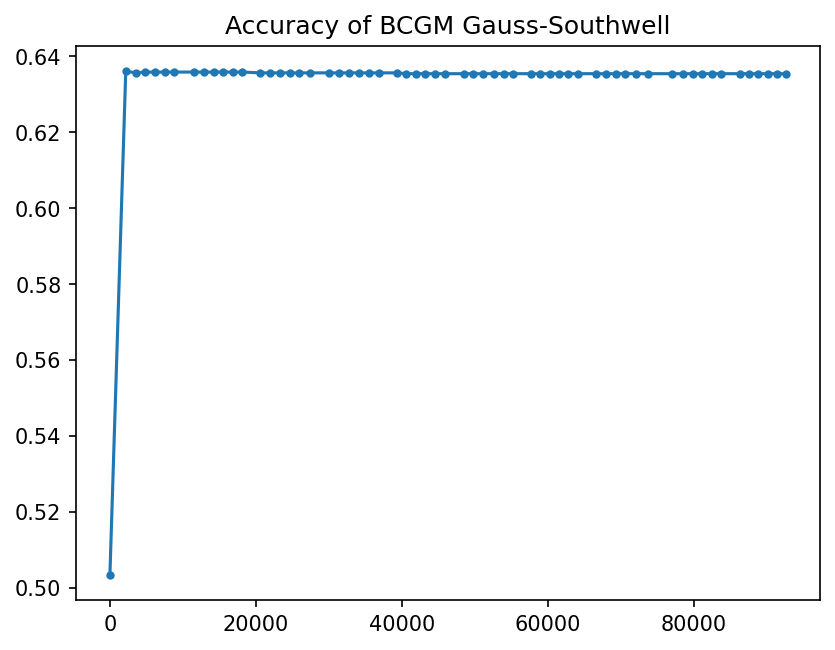

In [ ]:
plt.figure(dpi=150)
plt.title("Accuracy of BCGM Gauss-Southwell")
plt.plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')

### Loss

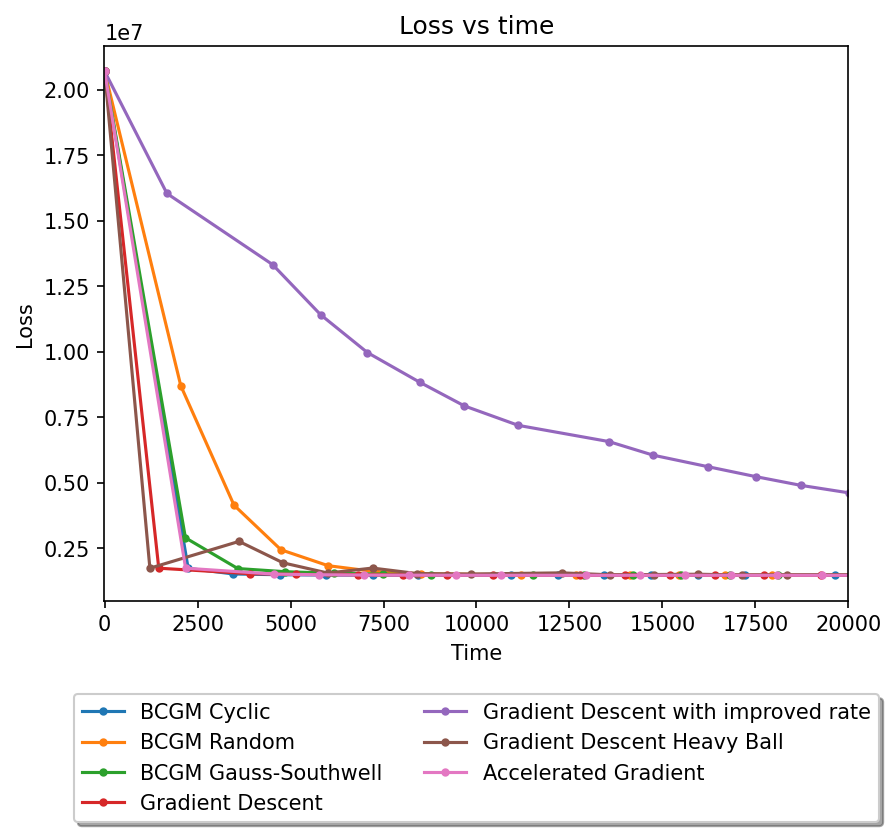

In [ ]:
plt.figure(dpi=150)
plt.plot(ticks_bcgd_cyclic , losses_bcgm_cyclic, marker='.')
plt.plot(ticks_bcgd_random , losses_bcgm_random, marker='.')
plt.plot(ticks_bcgd_gs , losses_bcgm_gs, marker='.')
plt.plot(ticks_gd , losses_gd, marker='.')
plt.plot(ticks_gd_improved , losses_gd_improved, marker='.')
plt.plot(ticks_gd_hb , losses_gd_hb, marker='.')
plt.plot(ticks_gd_accelerated , losses_gd_accelerated, marker='.')

plt.title("Loss vs time")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.xlim(-10,20000)
plt.legend(
    [
        'BCGM Cyclic',
        'BCGM Random',
        'BCGM Gauss-Southwell',
        'Gradient Descent',
        'Gradient Descent with improved rate',
        'Gradient Descent Heavy Ball',
        "Accelerated Gradient"
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2

)

## Accurancy

### Only BCGM compared

In [ ]:
min_acc = np.min(
    np.concatenate(
        (accuracies_bcgd_cyclic, accuracies_bcgd_random, accuracies_bcgd_gs)
    )
)
max_acc = np.max(
    np.concatenate(
        (accuracies_bcgd_cyclic, accuracies_bcgd_random, accuracies_bcgd_gs)
    )
)
min_y_plot = max(min_acc - .1 * (1 - min_acc), 0.5)
max_y_plot = max_acc + (.1 * (1 - max_acc))

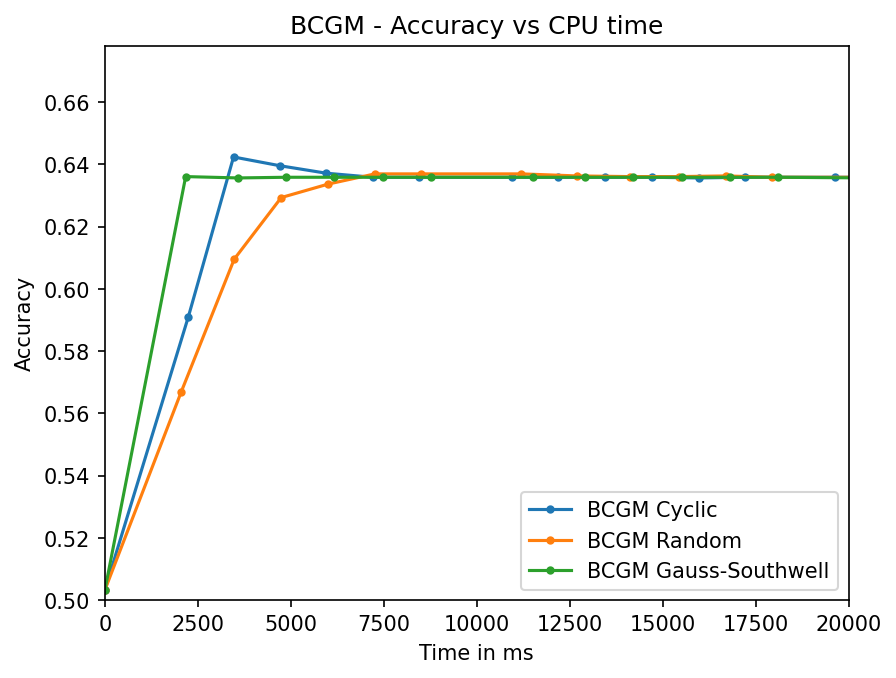

In [ ]:
plt.figure(dpi=150)
plt.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
plt.ylim(min_y_plot, max_y_plot)
plt.plot(ticks_bcgd_cyclic, accuracies_bcgd_cyclic, marker='.')
plt.plot(ticks_bcgd_random, accuracies_bcgd_random, marker='.')
plt.plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')

plt.title("BCGM - Accuracy vs CPU time")
plt.xlabel("Time in ms")
plt.ylabel("Accuracy")
plt.xlim(-10,20000)
plt.legend(
    ['BCGM Cyclic', 'BCGM Random', 'BCGM Gauss-Southwell'],
    loc="lower right"
)

### Only Gradient Descent Compared

In [ ]:
min_acc = np.min(
    np.concatenate(
        (accuracies_gd, accuracies_gd_hb, accuracies_gd_accelerated, accuracies_gd_improved)
    )
)
max_acc = np.max(
    np.concatenate(
        (accuracies_gd, accuracies_gd_hb, accuracies_gd_accelerated, accuracies_gd_improved)
    )
)
min_y_plot = max(min_acc - .1 * (1 - min_acc), 0.5)
max_y_plot = max_acc + (.1 * (1 - max_acc))

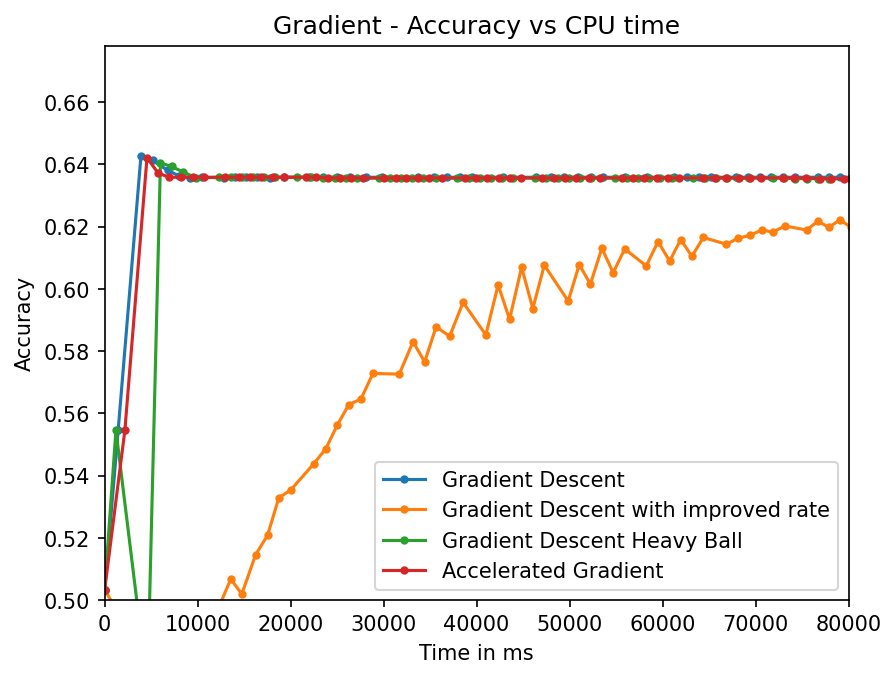

In [ ]:
plt.figure(dpi=150)
plt.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
plt.ylim(min_y_plot, max_y_plot)
plt.plot(ticks_gd, accuracies_gd, marker='.')
plt.plot(ticks_gd_improved, accuracies_gd_improved, marker='.')
plt.plot(ticks_gd_hb, accuracies_gd_hb, marker='.')
plt.plot(ticks_gd_accelerated, accuracies_gd_accelerated, marker='.')

plt.title("Gradient - Accuracy vs CPU time")
plt.xlabel("Time in ms")
plt.ylabel("Accuracy")
plt.xlim(-10,80000)
plt.legend(
    ['Gradient Descent', 'Gradient Descent with improved rate', 'Gradient Descent Heavy Ball', "Accelerated Gradient"],
    loc="lower right"
)